In [12]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import sklearn
import sys
import nltk
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import warnings
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import string
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
#from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel

import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel
import tqdm

Import data

In [32]:
data=pd.read_csv('datasets/3.NegativniLeme.csv')
len(data)
data.head(5)

,id,ida,text,textLatinica,preprocesirano,Leme
0,1.460000e+18,1,"УСА\nСмртни случајеви од ""КОВИД-19"" 2020. у од...","USA\nSmrtni slučajevi od ""KOVID-19"" 2020. u od...",usa smrtni slučajevi kovid odnosu godinu kada ...,USA smrtan slučaj kovid odnos godina kada biti...
1,1.460000e+18,2,Шта нам заправо говори главни човек у #USA 🇺🇸 ...,Šta nam zapravo govori glavni čovek u #USA 🇺🇸 ...,šta zapravo govori glavni čovek usa pitanju co...,što zapravo govoriti glavni čovek USA pitanje ...
2,1.460000e+18,3,@NSlavisa @DaZivimSan Пронађено је 2.433 случа...,@NSlavisa @DaZivimSan Pronađeno je 2.433 sluča...,pronađeno slučaja vakcina covid simptom prekin...,pronaći slučaj vakcina covid simptom prekinuti...
3,1.460000e+18,4,"Крије се састав #mRNA💉💉, јер је у питању, тобо...","Krije se sastav #mRNA💉💉, jer je u pitanju, tob...",krije sastav mrna pitanju tobož poslovna tajna...,kriti sastav mrn pitanje tobož poslovan tajna ...
4,1.460000e+18,5,@Dex60553256 @EBraunic @BratemiliM @BaOgra Eks...,@Dex60553256 @EBraunic @BratemiliM @BaOgra Eks...,eksperimentalne vakcine tipa sputnikv phajzer ...,eksperimentalan vakcina tip sputnikv phajzer n...


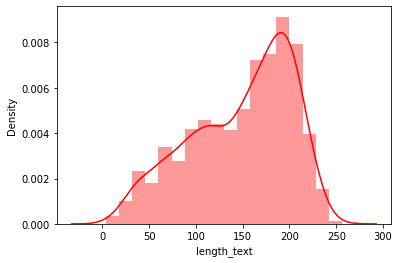

In [33]:
data['length_text'] = data['Leme'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

# Posle lema probati kako metoda radi ako se leme još stemuju

In [34]:
# A function to prepare the text for topic modelling
def words(text):
    dodatne_stop_reci=['tj','moći','niti','ali','što','imati','znati','hteti','ako','ni','koji','kada','biti']
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if not w in dodatne_stop_reci]
    return words

In [35]:
docs = [words(x) for x in data['Leme']]
#print("Docs ", docs)
# Create a dictionary representation of the documents. Dodeljuje svakoj reci iz korpusa jedinstveni ID
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))
print(dictionary)

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2, keep_n=1000)
print('Number of unique words after removing rare and common words:', len(dictionary))
print(dictionary)


Number of unique words in initital documents: 6751
Dictionary<6751 unique tokens: ['godina', 'kovid', 'odnos', 'povećanje', 'procenat']...>
Number of unique words after removing rare and common words: 531
Dictionary<531 unique tokens: ['godina', 'kovid', 'procenat', 'slučaj', 'smrtan']...>


Bag-of-word representation for a document using the doc2bow method

In [36]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(len(corpus))

1768


Primer vektorske reprezentacije jednog tvita

In [37]:
print(corpus[1])
bow_doc_x = corpus[1]
print("Duzina vektora",len(bow_doc_x))

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

[(7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]
Duzina vektora 11
Word 7 ("amp") appears 1 time.
Word 8 ("covid") appears 1 time.
Word 9 ("doktor") appears 1 time.
Word 10 ("glavni") appears 1 time.
Word 11 ("govoriti") appears 1 time.
Word 12 ("pandemija") appears 1 time.
Word 13 ("pfizer") appears 1 time.
Word 14 ("pitanje") appears 1 time.
Word 15 ("zapravo") appears 1 time.
Word 16 ("zaustaviti") appears 1 time.
Word 17 ("čovek") appears 1 time.


# Topic Modeling using LDA
LDA :: Latent Dirichlet Allocation is a probabilistic model. It is a unsupervised machine learning technique. And to obtain cluster assignments, it uses two probability values: P( word | topics) and P( topics | documents).

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The size of the bubble measures the importance of the topics, relative to the data. When we have 5 or 10 topics, we can see certain topics are clustered together (overlapping bubbles), this indicates the similarity between topics.

In [38]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=dictionary,
                                           num_topics=13, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=20,
                                           alpha='auto',
                                          # eta=0.91,
                                           per_word_topics=True)

In [40]:
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.065*"primiti" + 0.054*"lek" + 0.046*"doza" + 0.038*"drugi" + 0.032*"maska"')
(1, '0.044*"eksperimentalan" + 0.036*"pandemija" + 0.035*"nauka" + 0.033*"vakcinacija" + 0.033*"prvo"')
(2, '0.094*"eksperiment" + 0.040*"posledica" + 0.032*"proći" + 0.032*"nuspojava" + 0.032*"vakcinacija"')
(3, '0.073*"dnk" + 0.060*"menjati" + 0.038*"faza" + 0.033*"treći" + 0.029*"ispitivanje"')
(4, '0.060*"navesti" + 0.052*"emoji" + 0.038*"čovek" + 0.036*"rnk" + 0.033*"bolest"')
(5, '0.144*"sns" + 0.071*"jebati" + 0.051*"vakcinisati" + 0.048*"narod" + 0.040*"srbija"')
(6, '0.057*"vakcinisati" + 0.036*"čovjek" + 0.034*"protiv" + 0.031*"nuspojava" + 0.029*"dobiti"')
(7, '0.058*"postojati" + 0.052*"simptom" + 0.037*"godina" + 0.036*"eksperiment" + 0.026*"vidjeti"')
(8, '0.066*"isti" + 0.045*"kazati" + 0.043*"nuspojava" + 0.037*"kineski" + 0.033*"siguran"')
(9, '0.107*"virus" + 0.064*"zaštita" + 0.037*"vakcinisati" + 0.036*"reći" + 0.028*"štititi"')
(10, '0.169*"prevara" + 0.075*"nauka" + 0.042*"verovati

In [41]:
get_lda_topics(lda_model, 13)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13
0,primiti,eksperimentalan,eksperiment,dnk,navesti,sns,vakcinisati,postojati,isti,virus,prevara,čovjek,gejts
1,lek,pandemija,posledica,menjati,emoji,jebati,čovjek,simptom,kazati,zaštita,nauka,zemlja,bil
2,doza,nauka,proći,faza,čovek,vakcinisati,protiv,godina,nuspojava,vakcinisati,verovati,dete,otrov
3,drugi,vakcinacija,nuspojava,treći,rnk,narod,nuspojava,eksperiment,kineski,reći,velik,šteta,populacija
4,maska,prvo,vakcinacija,ispitivanje,bolest,srbija,dobiti,vidjeti,siguran,štititi,kovid,eksperiment,jedan
5,ništa,pravo,čovjek,veza,dobar,milion,velik,delovati,praviti,protiv,protiv,globus,umrijeti
6,sad,jasno,nitko,odmah,postojati,epidemija,grip,nijedan,dovoljno,covid,medicina,populacija,čip
7,dati,testirati,slučaj,cel,život,kovid,jedan,mrn,nemati,maska,kazati,zdravlje,bolest
8,lečiti,antivakser,obavezan,vek,eksperiment,otrovan,dva,pokazati,ostali,dan,test,zvati,čipovati
9,razumeti,mesec,vakcinisanje,itd,cilj,korona,godina,blag,bog,nov,dokazati,on,szo


In [42]:
pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.051993  0.187137       1        1  12.795129
6      0.035139  0.107113       2        1  10.305199
10     0.098756 -0.022195       3        1   9.548455
2     -0.125596 -0.067832       4        1   8.096755
12     0.066131  0.020028       5        1   7.160567
0      0.102278  0.040796       6        1   7.113845
1      0.075601 -0.091539       7        1   6.948403
5      0.203522  0.160001       8        1   6.860877
4     -0.209308  0.007465       9        1   6.785794
8      0.058426 -0.218831      10        1   6.673875
7     -0.276259  0.083747      11        1   6.651627
11     0.038362  0.053938      12        1   5.924362
3     -0.015059 -0.259827      13        1   5.135111, topic_info=            Term        Freq       Total Category  logprob  loglift
437      prevara  286.000000  286.000000  Default  30.0000  30.0000
458          sns  180.000000  180.000000  Default  29.0000  29.0000
428        gejts  156.000000  156.000000  Default  28.0000  28.0000
44         virus  262.000000  262.000000  Default  27.0000  27.0000
425          bil  131.000000  131.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
466  eksperiment   15.653441  264.722980  Topic13  -4.0423   0.1411
242       nemati   14.516568  187.994460  Topic13  -4.1177   0.4079
30         jedan   13.273291  127.396507  Topic13  -4.2073   0.7075
67           sad   11.995036  101.981474  Topic13  -4.3085   0.8288
122  vakcinacija   11.052354  130.045437  Topic13  -4.3904   0.5038

[598 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
465       2  0.935820       alo
7        13  0.878673       amp
115       5  0.125500  antitela
115       8  0.627498  antitela
115      11  0.250999  antitela
...     ...       ...       ...
446       4  0.434915   živjeti
156       2  0.176487     život
156       9  0.547109     život
156      11  0.158838     život
156      13  0.088243     život

[998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 11, 3, 13, 1, 2, 6, 5, 9, 8, 12, 4])

# Cherence and perplexity
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. But 
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”
A higher is always better(u_mass is between -14 and 14 and c_v is between 0 and 1)

In [30]:
# Compute Coherence Score u_mass
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score u_mass: ', coherence_lda)


Coherence Score u_mass:  -6.6494933669242


In [31]:
#Compute Coherence Score c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score c_v: ', coherence_lda)


Coherence Score c_v:  0.2706462923730758


In [27]:
#Compute Coherence Score npmi
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score c_npmi: ', coherence_lda)


Coherence Score c_npmi:  -0.1399591838945658


Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:
Number of Topics (K)
Dirichlet hyperparameter alpha: Document-Topic Density
Dirichlet hyperparameter beta: Word-Topic Density

In [1]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()